In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder

# 2.1

First, let's look at our data.

In [54]:
train = pd.read_csv('C:/datasets/sales/train_sls.csv')
test = pd.read_csv('C:/datasets/sales/test_sls.csv')

In [55]:
train.head()

,Unnamed: 0,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,location,shop_type,item_category,subcat,year,month,day,year-month
0,0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Ярославль,ТЦ,Кино,Blu-Ray,2013,1,2,2013-01
1,1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил,2013,1,3,2013-01
2,3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Москва,ТРК,Музыка,Винил,2013,1,6,2013-01
3,4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Москва,ТРК,Музыка,CD фирменного производства,2013,1,15,2013-01
4,5,2013-01-10,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,Москва,ТРК,Музыка,Музыкальное видео,2013,1,10,2013-01


We have a lot of categorical info. We can try to use label encoding.

In [56]:
#shop_name
train["loc_cd"] = LabelEncoder().fit_transform(train["location"])
train["shop_type_cd"] = LabelEncoder().fit_transform(train["shop_type"])
train.drop(["location"], axis=1, inplace=True)
train.drop(["shop_type"], axis=1, inplace=True)
#since we have already extracted feathures from this one
train.drop(["shop_name"], axis=1, inplace=True)

#item
train["item_cat_cd"] = LabelEncoder().fit_transform(train["item_category"])
train["subcat_cd"] = LabelEncoder().fit_transform(train["subcat"])
train.drop(["item_category"], axis=1, inplace=True)
train.drop(["subcat"], axis=1, inplace=True)
#since we have already extracted feathures from this one
train.drop(["item_category_name"], axis=1, inplace=True)

In [57]:
#shop_name
test["loc_cd"] = LabelEncoder().fit_transform(test["location"])
test["shop_type_cd"] = LabelEncoder().fit_transform(test["shop_type"])
test.drop(["location"], axis=1, inplace=True)
test.drop(["shop_type"], axis=1, inplace=True)
#since we have already extracted feathures from this one
test.drop(["shop_name"], axis=1, inplace=True)

#item
test["item_cat_cd"] = LabelEncoder().fit_transform(test["item_category"])
test["subcat_cd"] = LabelEncoder().fit_transform(test["subcat"])
test.drop(["item_category"], axis=1, inplace=True)
test.drop(["subcat"], axis=1, inplace=True)
#since we have already extracted feathures from this one
test.drop(["item_category_name"], axis=1, inplace=True)

Since there're a lot of unique names in item category and shop name and we already have corresponding values we will simply drop them.

In [58]:
train.drop(["item_name"], axis=1, inplace=True)

In [59]:
test.drop(["item_name"], axis=1, inplace=True)

We need to group data by month and shops.

In [60]:
train_ds = train.groupby(['date_block_num', 'loc_cd','shop_type_cd','shop_id','item_category_id','item_cat_cd', 'subcat_cd','item_id',]).agg({'item_cnt_day':'sum','item_price':'mean'}).reset_index()
train_ds.columns = ['date_block_num', 'loc_cd','shop_type_cd','shop_id','item_category_id','item_cat_cd','subcat_cd','item_id','item_cnt_monthly','mean_item_price']

In [61]:
train_ds.head()

,date_block_num,loc_cd,shop_type_cd,shop_id,item_category_id,item_cat_cd,subcat_cd,item_id,item_cnt_monthly,mean_item_price
0,0,0,5,2,2,1,12,5572,9.0,1532.857143
1,0,0,5,2,2,1,12,5573,2.0,924.000000
2,0,0,5,2,2,1,12,5575,4.0,955.005000
3,0,0,5,2,2,1,12,5576,3.0,2490.000000
4,0,0,5,2,2,1,12,5632,1.0,2390.000000


## Feature generation

Now we can try to generate some features. It is very possible that the quantity of goods sold depends on it's novelty.

In [62]:
#novelty
min_values = train_ds.groupby("item_id")["date_block_num"].min().reset_index()
min_values.columns = ['item_id','first_sales_date_block']
train_ds = pd.merge(train_ds, min_values, on='item_id', how = 'left')

In [63]:
train_ds['item_sales_dur'] = 33 - train_ds['first_sales_date_block']

Since price should be pretty relevant let's create difference features.

In [64]:
item_price = (train_ds.sort_values("date_block_num").groupby(["item_id"], as_index=False).agg({"mean_item_price": [np.min, np.max]}))
item_price.columns = ["item_id", "hist_min_item_price", "hist_max_item_price"]
train_ds = pd.merge(train_ds, item_price, on="item_id", how="left")

train_ds["price_inc"] = (train_ds["mean_item_price"] - train_ds["hist_min_item_price"])
train_ds["price_dec"] = (train_ds["hist_max_item_price"] - train_ds["mean_item_price"])

train_ds.drop(["hist_max_item_price"], axis=1, inplace=True)
train_ds.drop(["hist_min_item_price"], axis=1, inplace=True)

To follow seasonality we will add some lag features. Since there is an annual seasonality, 12-month lag should be added. Let's also try other periods (1,2,6 months).

In [65]:
def lag_features(df, lags, col_list):
    for col_name in col_list:
        tmp = df[["date_block_num", "shop_id", "item_id", col_name]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = [
                "date_block_num",
                "shop_id",
                "item_id",
                col_name + "_lag_" + str(i),
            ]
            shifted["date_block_num"] += i
            df = pd.merge(
                df, shifted, on=["date_block_num", "shop_id", "item_id"], how="left"
            )
    return df

In [66]:
# For target
train_ds = lag_features(train_ds, [1, 2, 3, 12], ["item_cnt_monthly"])

# For price
train_ds = lag_features(train_ds, [1, 2, 3, 12], ["mean_item_price"])

In [67]:
train_ds.fillna(0, inplace=True)

## Feature selection

We have quite a lot of features, now we need to choose which are more important than the others.

In [68]:
X_train = train_ds.drop(["item_cnt_monthly"], axis=1)

y_train = train_ds["item_cnt_monthly"]

In [69]:
#for numerical feathures
tr = train_ds.copy()
corr_matrix = tr.corr(method='spearman')
corr_matrix

,date_block_num,loc_cd,shop_type_cd,shop_id,item_category_id,item_cat_cd,subcat_cd,item_id,item_cnt_monthly,mean_item_price,...,price_inc,price_dec,item_cnt_monthly_lag_1,item_cnt_monthly_lag_2,item_cnt_monthly_lag_3,item_cnt_monthly_lag_12,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_12
date_block_num,1.000000,0.003877,-0.053118,0.024620,0.001210,0.006373,0.063674,-0.006981,0.005185,0.147790,...,0.046709,0.135222,0.064548,0.115411,0.149418,0.280964,0.092238,0.134623,0.163640,0.281650
loc_cd,0.003877,1.000000,-0.035750,0.957740,0.028019,0.022391,-0.009304,0.025040,0.006758,-0.052257,...,-0.038880,-0.017932,0.022340,0.020854,0.022295,0.008137,0.010740,0.011877,0.014811,0.006345
shop_type_cd,-0.053118,-0.035750,1.000000,0.056199,-0.018558,-0.016314,-0.028770,0.007069,0.003235,-0.001073,...,0.019722,0.007846,0.008556,0.010247,0.008406,0.001781,0.006984,0.008501,0.006988,0.001265
shop_id,0.024620,0.957740,0.056199,1.000000,0.028652,0.023117,-0.010997,0.025979,0.012955,-0.047266,...,-0.027654,-0.032213,0.036690,0.042084,0.041970,0.019722,0.022940,0.030187,0.032061,0.017326
item_category_id,0.001210,0.028019,-0.018558,0.028652,1.000000,0.982307,-0.004078,0.320639,-0.143711,-0.267162,...,-0.265061,-0.266684,-0.127704,-0.105396,-0.093043,-0.040142,-0.168602,-0.136593,-0.117759,-0.044271
item_cat_cd,0.006373,0.022391,-0.016314,0.023117,0.982307,1.000000,-0.085812,0.328311,-0.147473,-0.257270,...,-0.255096,-0.249439,-0.133187,-0.111024,-0.098503,-0.040785,-0.170599,-0.139356,-0.120812,-0.044230
subcat_cd,0.063674,-0.009304,-0.028770,-0.010997,-0.004078,-0.085812,1.000000,-0.168709,0.195005,0.322207,...,0.218864,0.093700,0.176972,0.165381,0.153252,0.076334,0.193316,0.177586,0.161495,0.076444
item_id,-0.006981,0.025040,0.007069,0.025979,0.320639,0.328311,-0.168709,1.000000,-0.109039,-0.279595,...,-0.199534,-0.108749,-0.110346,-0.106414,-0.104003,-0.073799,-0.151248,-0.139060,-0.130161,-0.078798
item_cnt_monthly,0.005185,0.006758,0.003235,0.012955,-0.143711,-0.147473,0.195005,-0.109039,1.000000,0.159222,...,0.170516,0.071151,0.367903,0.255674,0.196973,0.063995,0.299205,0.210093,0.164270,0.058706
mean_item_price,0.147790,-0.052257,-0.001073,-0.047266,-0.267162,-0.257270,0.322207,-0.279595,0.159222,1.000000,...,0.783266,0.123941,0.127431,0.096900,0.074564,0.005560,0.288200,0.222615,0.174749,0.024711


There are multicollinearity:
 - between shop_id and loc_cd;
 - between item_category_id and item_cat_cd;
 - between mean price and amount at the same lags.
Let's drop some of the features.

In [70]:
for_drop = [
        "loc_cd",
        "item_category_id",
        "mean_item_price_lag_1",##since it has lower correlation with target
        "mean_item_price_lag_2",
        "mean_item_price_lag_3",
        "mean_item_price_lag_12",
    ]

train_ds.drop(for_drop,axis=1, inplace=True,)

In [71]:
train_ds.shape

(1608224, 16)

## Data splits

In [72]:
x_train = train_ds.loc[train_ds["date_block_num"] < 33].drop(["item_cnt_monthly"], axis=1)
y_train = train_ds.loc[train_ds["date_block_num"] < 33]["item_cnt_monthly"]

x_val = train_ds.loc[train_ds["date_block_num"] == 33].drop(["item_cnt_monthly"], axis=1)
y_val = train_ds.loc[train_ds["date_block_num"] == 33]["item_cnt_monthly"]

## x_test and y_test should be taken from test dataset witch should be concated with train dataset
## with date_block_num = 34 

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
from sklearn.metrics import mean_squared_error as mse

prob_model = LinearRegression().fit(x_train, y_train)
print("Train rmse score: ",math.sqrt(mse(y_train, prob_model.predict(x_train))))
y_pred = prob_model.predict(x_val)
print("Validation rmse score: ", math.sqrt(mse(y_val,y_pred)))

Train rmse score:  6.0354126612891035
Validation rmse score:  4.9977648861198105


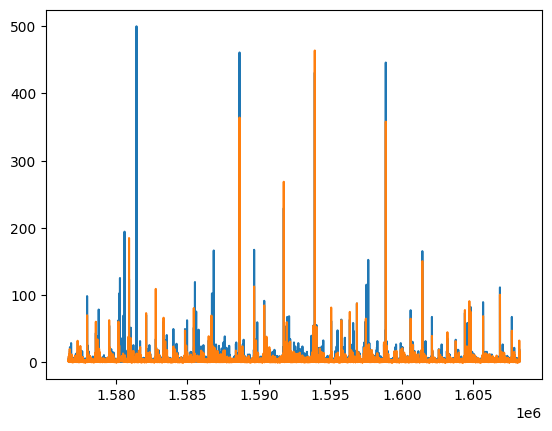

In [74]:
plt.plot(y_val.index, y_val.values)
plt.plot(y_val.index, y_pred)

Well.. In general the model is able to see some dependencies.